## Pairwise Model Training (RankNet)

### Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [3]:
import json
import numpy as np
import os
import pandas as pd
import pickle
import torch
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
data_dir = "/content/drive/MyDrive/data"

### Load Data

In [5]:
rows = []
with open(os.path.join(data_dir, "candidate-pair-feats.jsonl"), "r", encoding="utf-8") as f:
  for line in f:
    rows.append(json.loads(line.strip()))

len(rows), len(rows[0])

(9774, 63)

In [6]:
feats_df = pd.DataFrame(rows)
feats_df.head()

,query,doc_id,num_query_tokens,num_title_tokens,num_section_title_tokens,num_bread_crumb_tokens,num_text_tokens,num_title_token_overlap,num_section_title_token_overlap,num_bread_crumb_token_overlap,...,text_mean_tf,text_var_tf,text_min_tfidf,text_max_tfidf,text mean_tfidf,text_var_tfidf,title_vec_score,section_title_vec_score,bread_crumb_vec_score,text_vec_score
0,acute cholecystitis child,z_QzvYkBIHFsYVIUsjwX,3,1,2,5,286,0,0,0,...,2.077519,4.040502,0.183206,52.409880,6.227678,38.665046,0.817681,0.072743,0.211973,0.604541
1,acute cholecystitis child,zvQzvYkBIHFsYVIUsjwX,3,1,1,4,81,0,0,0,...,1.381818,0.745124,0.115926,29.645081,5.509683,32.488344,0.817681,0.110808,0.251098,0.647505
2,acute cholecystitis child,w_QzvYkBIHFsYVIUsjwX,3,1,1,2,269,0,0,0,...,1.984496,7.302085,0.205532,88.935242,6.872399,111.506575,0.817681,0.004833,0.022811,0.609198
3,acute cholecystitis child,1vQzvYkBIHFsYVIUsjwX,3,1,2,3,260,0,0,0,...,1.614865,1.425995,0.178530,44.552584,6.018126,42.014581,0.817681,0.141400,0.141922,0.503128
4,acute cholecystitis child,0PQzvYkBIHFsYVIUsjwX,3,1,2,5,57,0,0,0,...,1.062500,0.058594,0.044632,13.102470,4.007278,7.067541,0.817681,0.072743,0.211973,0.619005


In [7]:
# got these using polars
int_cols = ['num_query_tokens', 'num_title_tokens', 'num_section_title_tokens',
  'num_bread_crumb_tokens', 'num_text_tokens', 'num_title_token_overlap',
  'num_section_title_token_overlap', 'num_bread_crumb_token_overlap',
  'num_text_token_overlap', 'title_concept_overlap', 'section_title_concept_overlap',
  'bread_crumb_concept_overlap', 'text_concept_overlap', 'title_stygroup_overlap',
  'section_title_stygroup_overlap', 'bread_crumb_stygroup_overlap', 'text_stygroup_overlap',
  'title_ttf', 'title_min_tf', 'title_max_tf', 'section_title_ttf', 'section_title_min_tf',
  'section_title_max_tf', 'bread_crumb_ttf', 'bread_crumb_min_tf', 'bread_crumb_max_tf',
  'text_ttf', 'text_min_tf', 'text_max_tf']
float_cols = ['title_bm25_score', 'section_title_bm25_score', 'bread_crumb_bm25_score',
  'text_bm25_score', 'title mean_tf', 'title_var_tf', 'title_min_tfidf',
  'title_max_tfidf', 'title mean_tfidf', 'title_var_tfidf', 'section_title mean_tf',
  'section_title_var_tf', 'section_title_min_tfidf', 'section_title_max_tfidf',
  'section_title mean_tfidf', 'section_title_var_tfidf', 'bread_crumb mean_tf',
  'bread_crumb_var_tf', 'bread_crumb_min_tfidf', 'bread_crumb_max_tfidf',
  'bread_crumb mean_tfidf', 'bread_crumb_var_tfidf', 'text_mean_tf', 'text_var_tf',
  'text_min_tfidf', 'text_max_tfidf', 'text mean_tfidf', 'text_var_tfidf',
  'title_vec_score', 'section_title_vec_score', 'bread_crumb_vec_score', 'text_vec_score']


def scale_features(df, int_cols, float_cols):
  feature_scalers = {}
  for colname in int_cols:
    scaler = MinMaxScaler()
    df[colname] = scaler.fit_transform(df[colname].values.reshape(-1, 1))
    feature_scalers[colname] = scaler
  for colname in float_cols:
    scaler = StandardScaler()
    df[colname] = scaler.fit_transform(df[colname].values.reshape(-1, 1))
    feature_scalers[colname] = scaler
  return feature_scalers


feat_scalers = scale_features(feats_df, int_cols, float_cols)
with open(os.path.join(data_dir, "feat_scalers_model2.pickle"), "wb") as handle:
    pickle.dump(feat_scalers, handle, protocol=pickle.HIGHEST_PROTOCOL)

feats_df.head()

,query,doc_id,num_query_tokens,num_title_tokens,num_section_title_tokens,num_bread_crumb_tokens,num_text_tokens,num_title_token_overlap,num_section_title_token_overlap,num_bread_crumb_token_overlap,...,text_mean_tf,text_var_tf,text_min_tfidf,text_max_tfidf,text mean_tfidf,text_var_tfidf,title_vec_score,section_title_vec_score,bread_crumb_vec_score,text_vec_score
0,acute cholecystitis child,z_QzvYkBIHFsYVIUsjwX,0.142857,0.0,0.076923,0.153846,0.399160,0.0,0.0,0.0,...,0.364698,0.241443,-0.001640,0.670879,0.277502,-0.042268,2.307407,-0.552643,0.262564,1.548865
1,acute cholecystitis child,zvQzvYkBIHFsYVIUsjwX,0.142857,0.0,0.000000,0.115385,0.112045,0.0,0.0,0.0,...,-0.541700,-0.509747,-0.192268,-0.279445,-0.065440,-0.144076,2.307407,-0.288950,0.535107,1.781858
2,acute cholecystitis child,w_QzvYkBIHFsYVIUsjwX,0.142857,0.0,0.000000,0.038462,0.375350,0.0,0.0,0.0,...,0.243503,0.984930,0.061616,2.195643,0.585445,1.158350,2.307407,-1.023082,-1.055155,1.574122
3,acute cholecystitis child,1vQzvYkBIHFsYVIUsjwX,0.142857,0.0,0.076923,0.076923,0.362745,0.0,0.0,0.0,...,-0.238074,-0.354541,-0.014889,0.342874,0.177411,0.012941,2.307407,-0.077022,-0.225419,0.998911
4,acute cholecystitis child,0PQzvYkBIHFsYVIUsjwX,0.142857,0.0,0.076923,0.153846,0.078431,0.0,0.0,0.0,...,-0.957725,-0.666244,-0.394269,-0.970021,-0.783046,-0.563077,2.307407,-0.552643,0.262564,1.627302


In [8]:
data_df = pd.read_csv(os.path.join(data_dir, "candidate-pair-judgements.tsv"),
                      header=0, sep="\t")
data_df.head()

,QUESTION,DOCUMENT-1,DOCUMENT-2,JUDGEMENT
0,acute cholecystitis child,z_QzvYkBIHFsYVIUsjwX,zvQzvYkBIHFsYVIUsjwX,DOCUMENT-1
1,acute cholecystitis child,z_QzvYkBIHFsYVIUsjwX,w_QzvYkBIHFsYVIUsjwX,DOCUMENT-2
2,acute cholecystitis child,z_QzvYkBIHFsYVIUsjwX,1vQzvYkBIHFsYVIUsjwX,DOCUMENT-2
3,acute cholecystitis child,z_QzvYkBIHFsYVIUsjwX,0PQzvYkBIHFsYVIUsjwX,DOCUMENT-2
4,acute cholecystitis child,z_QzvYkBIHFsYVIUsjwX,JeoAvYkBlUvzL_haaJUE,DOCUMENT-1


### Dataset

In [9]:
class PairwiseDataset(Dataset):
  def __init__(self, data_df, feats_df):
    self.feats_df = feats_df
    self.data_df = data_df

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, idx):
    row = self.data_df.loc[idx]
    query = row["QUESTION"]
    docid_1 = row["DOCUMENT-1"]
    docid_2 = row["DOCUMENT-2"]
    label = [1, 0] if row["JUDGEMENT"] == "DOCUMENT-1" else [0, 1]
    try:
      x1 = torch.from_numpy(
          self.feats_df[(self.feats_df["query"] == query) &
                        (self.feats_df["doc_id"] == docid_1)]
          .values[0, 2:]
          .astype(np.float32)
      )
      x2 = torch.from_numpy(
          self.feats_df[(self.feats_df["query"] == query) &
                        (self.feats_df["doc_id"] == docid_2)]
          .values[0, 2:]
          .astype(np.float32)
      )
      label = torch.tensor(label, dtype=torch.float32)
    except IndexError as e:
      print("query:", query, "docid_1:", docid_1, "docid_2:", docid_2)
      raise e
    return {
        "x1": x1, "x2": x2, "label": label
    }


pair_dataset = PairwiseDataset(data_df, feats_df)
pair_loader = DataLoader(pair_dataset, batch_size=3)
for pair_data in pair_loader:
  x1 = pair_data["x1"]
  x2 = pair_data["x2"]
  label = pair_data["label"]
  print(x1.shape, x2.shape, label.shape)
  break

torch.Size([3, 61]) torch.Size([3, 61]) torch.Size([3, 2])


In [10]:
train_ds, val_ds, test_ds = random_split(
    pair_dataset, [0.8, 0.15, 0.05],
    generator=torch.Generator().manual_seed(42))
len(train_ds), len(val_ds), len(test_ds)

(7644, 1433, 477)

In [11]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE)

### Model

In [12]:
class PairwiseModel(torch.nn.Module):
  def __init__(self):
    super(PairwiseModel, self).__init__()
    self.fc1 = torch.nn.Linear(61, 128)
    self.fc2 = torch.nn.Linear(128, 32)
    self.fc3 = torch.nn.Linear(32, 2)

  def forward(self, x):
    x1, x2 = x

    z1 = self.fc1(x1)
    z1 = F.relu(z1)
    z1 = self.fc2(z1)
    z1 = F.relu(z1)
    z1 = self.fc3(z1)
    z1 = F.relu6(z1)

    z2 = self.fc1(x2)
    z2 = F.relu(z2)
    z2 = self.fc2(z2)
    z2 = F.relu(z2)
    z2 = self.fc3(z2)
    z2 = F.relu6(z2)

    y = z1 - z2
    y = F.sigmoid(y)
    return y


model = PairwiseModel()
for batch in pair_loader:
  x1, x2 = batch["x1"], batch["x2"]
  x = (x1, x2)
  y = model(x)
  break
print(y)

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.4950]], grad_fn=<SigmoidBackward0>)


### Training Loop

In [13]:
NUM_EPOCHS = 50
LEARNING_RATE = 5e-4

In [14]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
def train_epoch(model):
  model.train(True)
  losses = []
  for data in train_dataloader:
    x1, x2, label = data["x1"], data["x2"], data["label"]
    x1, x2, label = x1.to(device), x2.to(device), label.to(device)

    optimizer.zero_grad()
    output = model((x1, x2))
    loss = loss_fn(output, label)
    loss.backward()
    optimizer.step()

    losses.append(loss)

  loss = torch.mean(torch.stack(losses))
  return loss


def validate_epoch(model):
  model.eval()
  losses = []
  with torch.no_grad():
    for data in val_dataloader:
      x1, x2, label = data["x1"], data["x2"], data["label"]
      x1, x2, label = x1.to(device), x2.to(device), label.to(device)

      output = model((x1, x2))
      loss = loss_fn(output, label)
      losses.append(loss)

  loss = torch.mean(torch.stack(losses))
  return loss


history = []
for epoch in range(NUM_EPOCHS):
  train_loss = train_epoch(model)
  val_loss = validate_epoch(model)
  history.append((epoch + 1, train_loss.item(), val_loss.item()))
  print("Epoch {:02d} | Train Loss: {:.3f} | Validation Loss: {:.3f}".format(
      epoch + 1, train_loss, val_loss))

Epoch 01 | Train Loss: 0.657 | Validation Loss: 0.621
Epoch 02 | Train Loss: 0.606 | Validation Loss: 0.599
Epoch 03 | Train Loss: 0.584 | Validation Loss: 0.588
Epoch 04 | Train Loss: 0.567 | Validation Loss: 0.583
Epoch 05 | Train Loss: 0.555 | Validation Loss: 0.568
Epoch 06 | Train Loss: 0.543 | Validation Loss: 0.566
Epoch 07 | Train Loss: 0.534 | Validation Loss: 0.558
Epoch 08 | Train Loss: 0.523 | Validation Loss: 0.564
Epoch 09 | Train Loss: 0.512 | Validation Loss: 0.551
Epoch 10 | Train Loss: 0.503 | Validation Loss: 0.549
Epoch 11 | Train Loss: 0.497 | Validation Loss: 0.544
Epoch 12 | Train Loss: 0.486 | Validation Loss: 0.544
Epoch 13 | Train Loss: 0.481 | Validation Loss: 0.536
Epoch 14 | Train Loss: 0.473 | Validation Loss: 0.529
Epoch 15 | Train Loss: 0.466 | Validation Loss: 0.533
Epoch 16 | Train Loss: 0.460 | Validation Loss: 0.529
Epoch 17 | Train Loss: 0.458 | Validation Loss: 0.534
Epoch 18 | Train Loss: 0.449 | Validation Loss: 0.527
Epoch 19 | Train Loss: 0.446

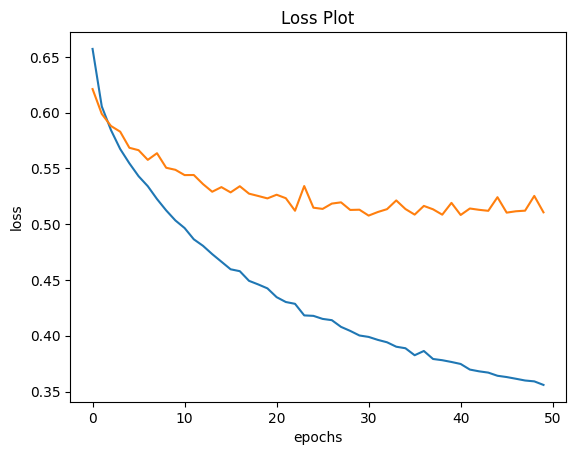

In [17]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(NUM_EPOCHS)
train_losses = [h[1] for h in history]
val_losses = [h[2] for h in history]
plt.plot(xs, train_losses, label="train")
plt.plot(xs, val_losses, label="val")
plt.title("Loss Plot")
plt.xlabel("epochs")
plt.ylabel("loss")

_ = plt.show()

In [18]:
torch.save(model.state_dict(),
           os.path.join(data_dir, "pairwise_model.pt"))

### Evaluation on Test set

In [21]:
from sklearn.metrics import classification_report

labels, predictions = [], []
model.eval()
for data in test_dataloader:
    x1, x2, lbls = data["x1"], data["x2"], data["label"]
    x1, x2, lbls = x1.to(device), x2.to(device), lbls.to(device)

    with torch.no_grad():
      preds = model((x1, x2))
      for pred, label in zip(preds, lbls):
        predictions.append(0 if pred[0] < pred[1] else 1)
        labels.append(0 if label[0] < label[1] else 1)

print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       205
           1       0.82      0.82      0.82       272

    accuracy                           0.79       477
   macro avg       0.79      0.79      0.79       477
weighted avg       0.79      0.79      0.79       477

